In [88]:
import os
import tarfile
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score

%matplotlib inline

In [15]:
# Install package

!pip install scikit-learnSimpleImputer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 10.5 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 16.4 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 16.9 MB/s eta 0:00:00


In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
# Check out what categories exist and how many instance belong to each category.

housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

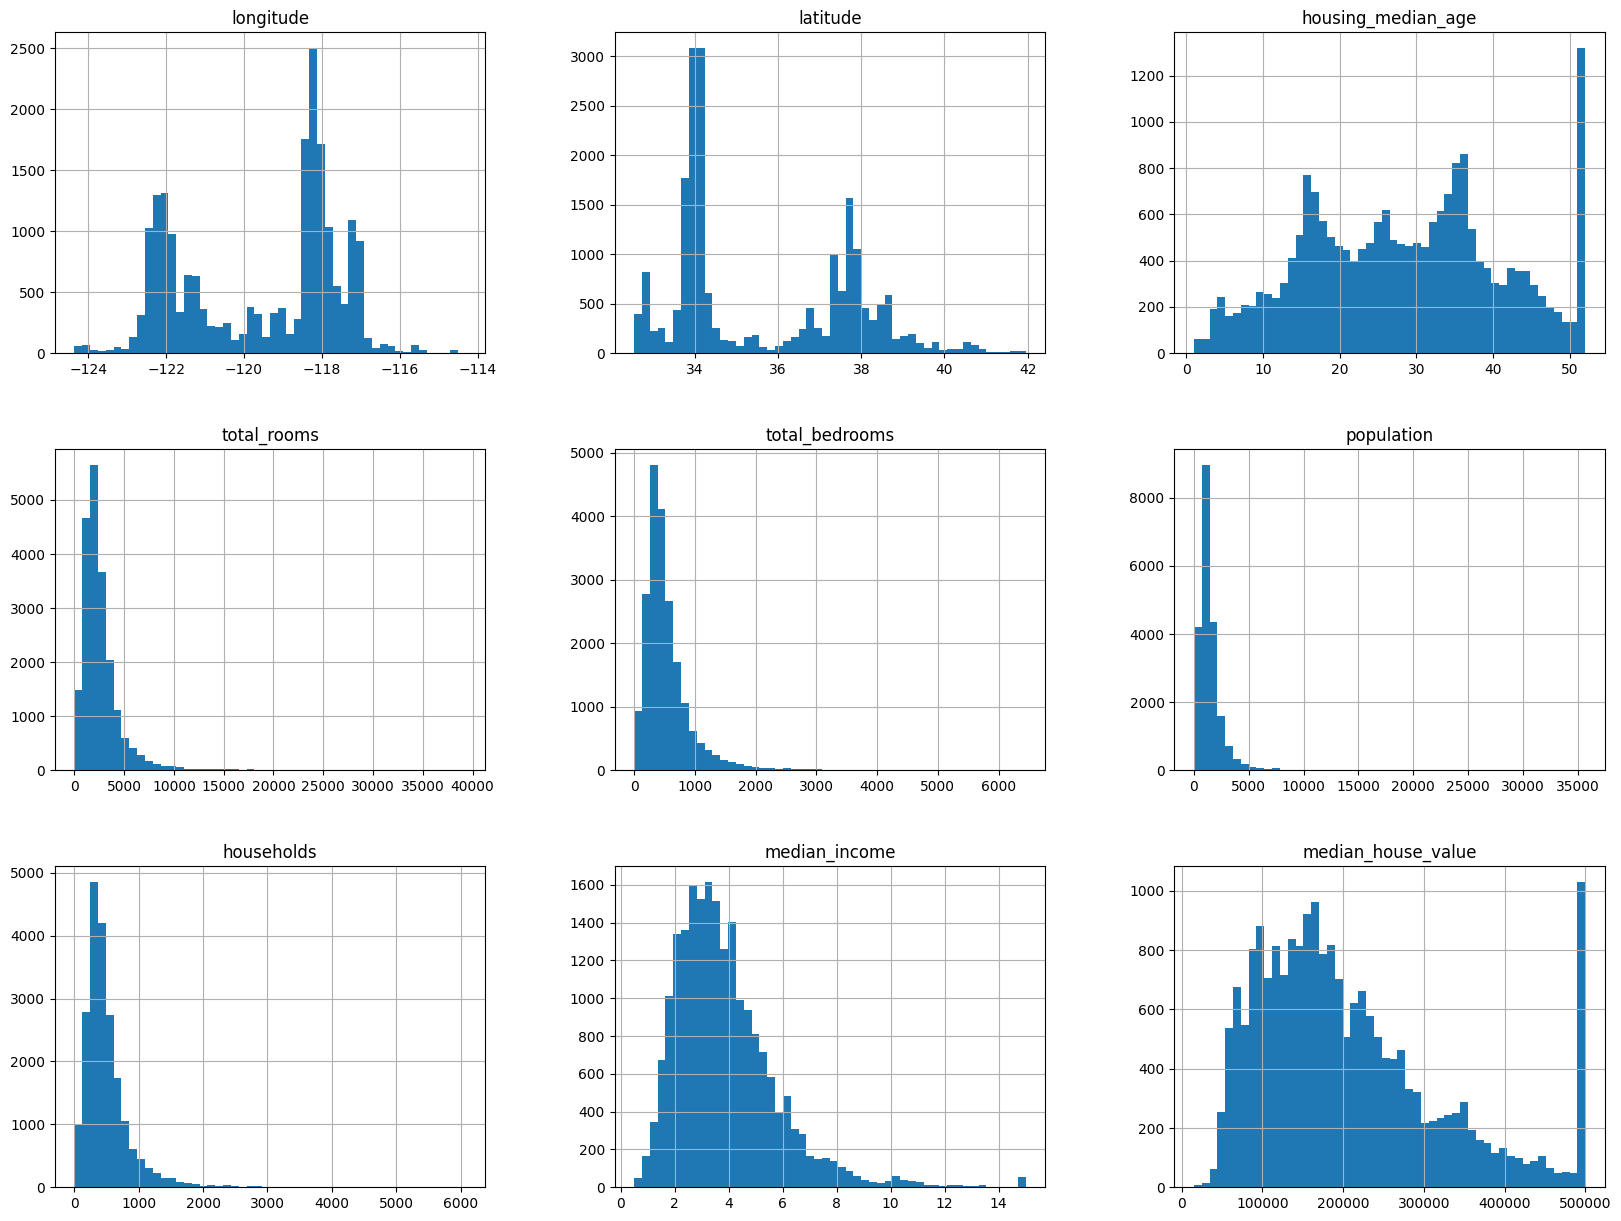

In [10]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [11]:
# Split train-test

# It is purely random sampleing methods. It dataset isn't large enough. It risk of introducing a significant sampling bias.
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=13)

In [12]:
# Use startified sampling to reduce a significant sampling bias.

# Create category data from importance feature that will use with startified sampling.
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf], labels = [1, 2, 3, 4, 5])

<AxesSubplot: >

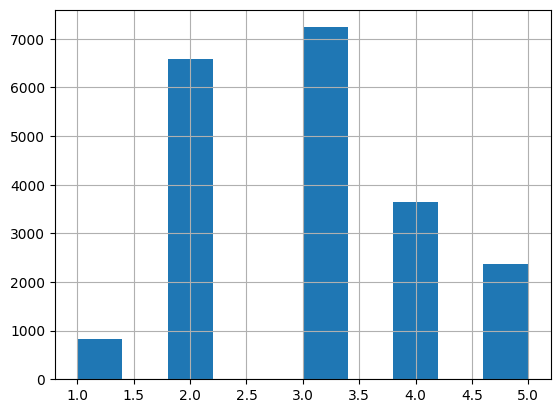

In [13]:
housing["income_cat"].hist()

In [14]:
# Stratified split

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=13)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    start_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [15]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [16]:
# Remove index columns

for set_ in (start_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Data Visualization

In [17]:
# Copy to prevent with prepared data

housing = start_train_set.copy()

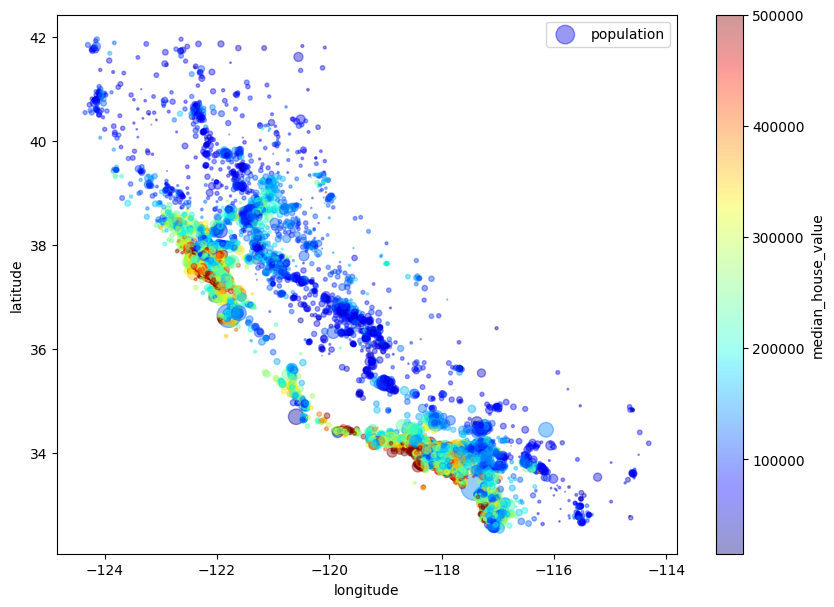

In [18]:
housing.plot(
    kind="scatter", 
    x="longitude", 
    y="latitude", 
    s=housing["population"]/100,  # Radius size
    label="population",
    figsize=(10,7),
    c="median_house_value",       # Color
    cmap=plt.get_cmap("jet"),
    colorbar=True,
    alpha=0.4)

plt.legend()

# Check colleration

In [19]:
corr_matrix = housing.corr()

/var/folders/mj/l4cp0_0x5h715ylftq8rhpn80000gn/T/ipykernel_7963/2466220658.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


In [20]:
# Check correlation with the median house value

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689012
total_rooms           0.137550
housing_median_age    0.100720
households            0.069836
total_bedrooms        0.054392
population           -0.022648
longitude            -0.041552
latitude             -0.147311
Name: median_house_value, dtype: float64

## Warning
The correlation cpefficient only measures linear correlation. 

array([[<AxesSubplot: xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot: xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot: xlabel

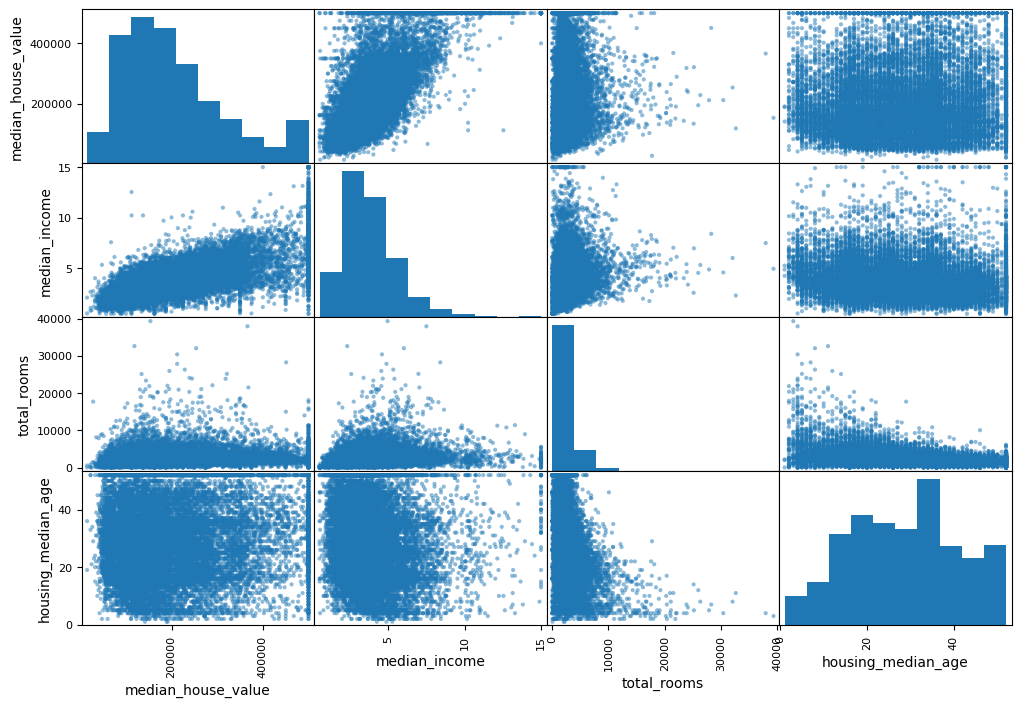

In [21]:
# Another way to check correlation

from pandas.plotting import scatter_matrix

# features to check correlation
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

<AxesSubplot: xlabel='median_income', ylabel='median_house_value'>

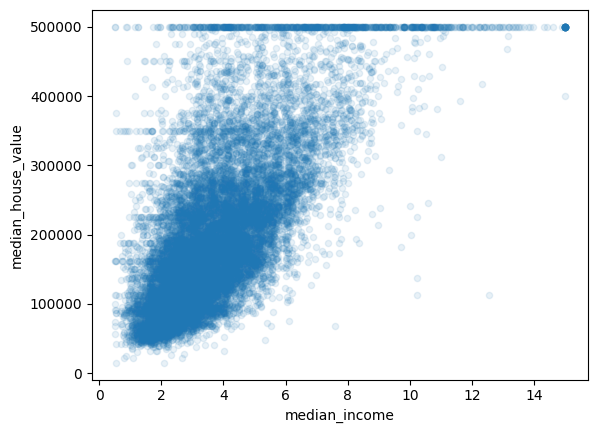

In [22]:
# Check correlation between 2 features
housing.plot(
    kind="scatter",
    x="median_income",
    y="median_house_value",
    alpha=0.1
)

# Experimentign with attribute combinations
Some attributes have a tail-heavy distrubution, so you may want to transform them.

In [23]:
# Try out various attribute combinations -> Feature engineering
housing["room_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [24]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

/var/folders/mj/l4cp0_0x5h715ylftq8rhpn80000gn/T/ipykernel_7963/826279322.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.689012
room_per_household          0.154018
total_rooms                 0.137550
housing_median_age          0.100720
households                  0.069836
total_bedrooms              0.054392
population_per_household   -0.022270
population                 -0.022648
longitude                  -0.041552
latitude                   -0.147311
bedrooms_per_room          -0.255797
Name: median_house_value, dtype: float64

# Prepare the data for Machine Learning

In [25]:
# Copy the training set and separate the predictors and labels
housing = start_train_set.drop("median_house_value", axis=1)
housing_labels = start_train_set["median_house_value"].copy()

## Data cleaning

In [26]:
# Hadle missing values

#1. Get rid of the whole attribute
# housing.drop("total_bedrooms", axis=1)

#2. Get rid of some data point 
# housing.dropna(subset=["total_bedrooms"])

#3. Set the values to some value (zero, mean, median, etc.) -> This case we have to calculate the value from the train set and use this value in both train and test set ***
# housing["total_bedrooms"].fillna(median, inplace=True)

In [27]:
# Calculate the median

imputer = SimpleImputer(strategy="median")

# Because the imputer will work with only the numerical data then we have to drop the feature that type isn't numerical.
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [28]:
imputer.statistics_

array([-118.49  ,   34.25  ,   29.    , 2121.    ,  433.    , 1166.    ,
        408.    ,    3.5394])

In [29]:
# Use this "trained" imputer to transform the training set by replacing missing values
# with the learned medians.

X = imputer.transform(housing_num)

In [30]:
# The transform result is exists in the numpy array format

print(type(X))

<class 'numpy.ndarray'>


In [31]:
# Convert numpy to be pandas DataFrame

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

## Scikit-learn design

Scikit-learn's API is remakably well designed. These are the main design principles.

Consistency: All object share a consistent and simple interface.

1. Estimator
2. Transformer
3. Predictor
4. Inspection
5. Nonproliferation of classes
6. Composition
7. Sensible defaults

# Handle categorical data

In [32]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(3)

,ocean_proximity
3061,INLAND
4123,<1H OCEAN
7979,<1H OCEAN


In [33]:
# Convert category from text to number

ordinal_encoder = OrdinalEncoder()
housing_cat_encoder = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoder[:5]

array([[1.],
       [0.],
       [0.],
       [0.],
       [3.]])

In [34]:
# Check catigory in the encoder
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [38]:
# Because number in catergorical data has effect to ML then sometime we need a different encoder -> Onehot encoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot # The resul is type SciPy sparse matrix -> store only value isn't zero.

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [39]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

# Custom Transformers

You can create custom transformer to work seamlessly witj Scikit-Learn functionalities.
All you need to di is create a class and implement three method: fit()(returning self), transform(), and fit_transform()

Fit: It will calculate some values that use in the transform method later.

ex. standardScaler.fit(X) -> It will calculate mean and standard deviation that will apply in transform phase.


Transform: Apply the values that calculate from Fit to every data point in the feature.

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

In [57]:
class CombineAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # No *args ro **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[: , population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [58]:
attr_adder = CombineAttributesAdder(add_bedrooms_per_room=False)
house_extra_attribs = attr_adder.transform(housing.values)

In [60]:
house_extra_attribs

array([[-119.29, 35.76, 15.0, ..., 'INLAND', 5.127604166666667,
        4.557291666666667],
       [-118.22, 34.14, 50.0, ..., '<1H OCEAN', 5.678571428571429,
        2.6785714285714284],
       [-118.17, 33.87, 49.0, ..., '<1H OCEAN', 4.402272727272727,
        3.043181818181818],
       ...,
       [-117.98, 33.75, 37.0, ..., '<1H OCEAN', 4.6300366300366305,
        2.868131868131868],
       [-117.04, 32.63, 26.0, ..., 'NEAR OCEAN', 6.924623115577889,
        2.92964824120603],
       [-121.28, 37.98, 52.0, ..., 'INLAND', 5.502923976608187,
        2.4210526315789473]], dtype=object)

# Transformation Pipeline

The pipeline class will help with the sequences of transformations.

The pipeline constructor takes a list of name/estimator pairs definig a sequences of steps. 

When you call Pipeline's fit() method, it calls fit_transform() sequentially on all transformer,
passing the output of each call as the parameter to the next call until it reaches the final estimator,
for which it calls the fit() method.


In [69]:
# Prepare pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombineAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [70]:
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[ 0.13887721,  0.06059886, -1.09190211, ..., -0.12071167,
         0.12473463, -0.200419  ],
       [ 0.6735369 , -0.69784215,  1.69144483, ...,  0.10021151,
        -0.03716681, -0.3046254 ],
       [ 0.698521  , -0.82424899,  1.61192063, ..., -0.41155024,
        -0.00574598,  0.25288554],
       ...,
       [ 0.79346057, -0.8804298 ,  0.65763025, ..., -0.32022298,
        -0.02083116,  0.05286334],
       [ 1.26316161, -1.40478409, -0.21713593, ...,  0.59984501,
        -0.0155299 , -0.92917971],
       [-0.85548989,  1.09994396,  1.85049323, ...,  0.02978157,
        -0.05935886, -0.27476606]])

### Full pipeline: Transform both numeric and categorical within on pipe line

1. import ColumnTransformer
2. Get list of numerical column names
3. Get list of categorical column names
4. Construct  a ColumnTransformer
- Require a list of tuples (name, transformer, list of column name)
- transformer is able to be pipeline or transformer

In [75]:
# Make single transformer able to handle all columns (both numeric and categorical)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

In [76]:
housing_prepared = full_pipeline.fit_transform(housing)

# Select and Train Model

In [78]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [82]:
some_data = housing.iloc[:5]
some_label = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print(f"Predictions: {lin_reg.predict(some_data_prepared)}")
print(f"Labels: {list(some_label)}")

Predictions: [ 36946.5563308  313665.89888857 209656.66910664 253957.46387696
 185395.31808985]
Labels: [59800.0, 258100.0, 162800.0, 228800.0, 111100.0]


In [84]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67928.2470529133

In [86]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [87]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# Cross-Validation

The following code randomly splits the training set into K distinct subsets called folds, 
then it trains and evaluates the model K times. The result is an array containing the 10 evaluation scores.

In [89]:
scores = cross_val_score(
    tree_reg, 
    housing_prepared, 
    housing_labels,
    scoring="neg_mean_squared_error",
    cv=10
)

In [92]:
tree_rmse_scores = np.sqrt(-scores) # Why we use -score here?

In [93]:
tree_rmse_scores

array([70762.72907191, 68593.61202988, 67793.61660492, 72335.55926637,
       69412.89834815, 67622.90991254, 67818.77104935, 70278.62048872,
       69640.92142942, 76092.85218982])

In [96]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std()) 

In [97]:
display_scores(tree_rmse_scores)

Scores: [70762.72907191 68593.61202988 67793.61660492 72335.55926637
 69412.89834815 67622.90991254 67818.77104935 70278.62048872
 69640.92142942 76092.85218982]
Mean: 70035.24903910827
Standard deviation: 2468.8588974879917
